In [1]:
from motion_code import MotionCode
import numpy as np
from utils import plot_timeseries, plot_motion_codes
from data_processing import load_data

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
name = 'Sound'
load_existing_data = False
if load_existing_data:
    data_path = 'data/noisy/' + name
    data = np.load(data_path + '.npy', allow_pickle=True).item()
    Y_train, labels_train = data.get('X_train'), data.get('y_train')
    Y_test, labels_test = data.get('X_test'), data.get('y_test')
else:
    Y_train, labels_train = load_data(name, split='train')
    Y_test, labels_test = load_data(name, split='test')

/mnt/c/Users/nguyn/Documents/github/motion_code/data_processing.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(file_name)


In [3]:
from data_processing import process_data_for_motion_codes

In [4]:
X_train, Y_train, labels_train = process_data_for_motion_codes(Y_train, labels_train)
X_test, Y_test, labels_test = process_data_for_motion_codes(Y_test, labels_test)

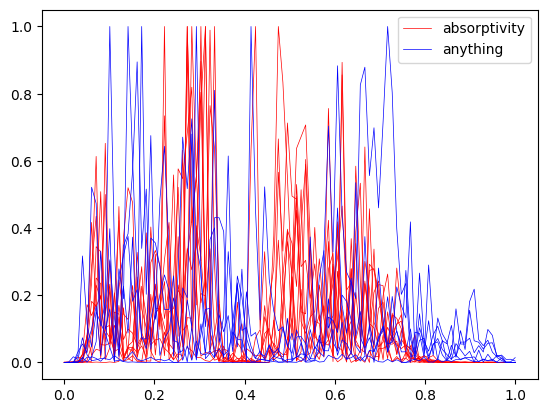

<Figure size 640x480 with 0 Axes>

In [5]:
label_names = ['absorptivity', 'anything']
plot_timeseries(X_train, Y_train, labels_train, label_names=label_names,
                        output_file='out/plot_train_uneven_length.png')

In [6]:
X_train, X_test, Y_train, Y_test = list(X_train), list(X_test), list(Y_train), list(Y_test)

In [7]:
def randomly_remove_data_points(X, Y, low_percent=0.8, high_percent=0.9):
    X_removed = []
    Y_removed = []
    num_series = len(X_train)
    for s in range(num_series):
        series_len = X_train[s].shape[0]
        num_remained = np.random.randint(low=int(low_percent*series_len), 
                                         high=int(high_percent*series_len))
        idx = np.sort(np.random.choice(np.arange(series_len), size=num_remained, replace=False))
        X_removed.append(np.copy(X_train[s][idx]))
        Y_removed.append(np.copy(Y_train[s][idx]))
    
    return X_removed, Y_removed

In [8]:
np.random.seed(seed=41)
X_train_removed, Y_train_removed = randomly_remove_data_points(X_train, Y_train, low_percent=0.8, high_percent=0.95)

In [9]:
print([s.shape[0] for s in X_train_removed])

[80, 81, 84, 81, 90, 80, 93, 90, 91, 94, 81, 94, 91, 82, 89, 94]


In [10]:
# Build motion code
model = MotionCode(m=10, Q=1, latent_dim=2, sigma_y=0.1)

# Train model on unequal length Sound data
model_path = 'saved_models/' + 'test_model_unequal_length'
model.fit(X_train_removed, Y_train_removed, labels_train, model_path)

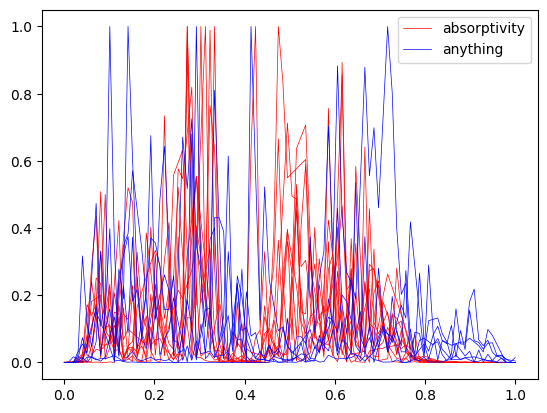

<Figure size 640x480 with 0 Axes>

In [11]:
plot_timeseries(X_train_removed, Y_train_removed, labels_train, label_names=label_names,
                        output_file='out/plot_train_uneven_length_removed.png')

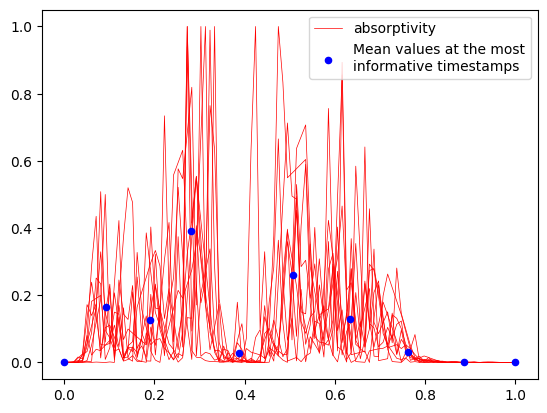

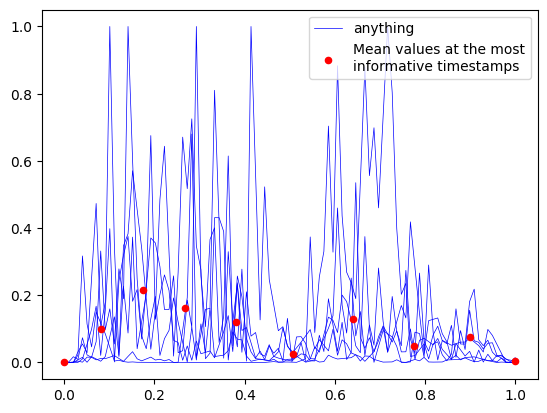

<Figure size 640x480 with 0 Axes>

In [12]:
model.load(model_path)
plot_motion_codes(X_train_removed, Y_train_removed, None, labels_train, label_names,
                    model, output_dir='out/multiple/uneven_length',
                    additional_data={'X': np.array(X_train), 'Y': np.array(Y_train)})